In [121]:
import os
import sys
import json
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt



TEXT_DIM = 1024
VAE_LATENT_DIM = 1536
HIDDEN_DIM = TEXT_DIM
BATCH_SIZE = 1024*2
LEARNING_RATE = 0.0001
NUM_EPOCHS = 50

L2_NORM = 0.15
DROPOUT_RATE = 0.5
MAX_GRAD_NORM = 1.

REQUIRED_SUBMISSION_ROWS = 1500


PROCESSED_DATA_FILE = f'/kaggle/input/aml-competition/train/train/train.npz'
TEST_EMBEDDINGS_FILE = f'/kaggle/input/aml-competition/test/test/test.clean.npz'
MODEL_SAVE_PATH = 'best_translator_model.pt'
SUBMISSION_FILE = 'submission.csv'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cuda')

In [ ]:


def check_file_exists(file_path):
    if not os.path.exists(file_path):
        print(f"FATAL ERROR: Required file not found at: {file_path}")
        sys.exit(1)
    return file_path

def polynomial_kernel_similarity(x, y, alpha=1.0, c=1.0, degree=2):
    """
    Compute the Polynomial Kernel similarity between two sets of vectors.
    K(x, y) = (alpha * x^T y + c)^degree
    """
    return (alpha * torch.matmul(x, y.T) + c) ** degree

def adaptive_infoNCE_loss(z, positives, temperature=0.005,
                          alpha_poly=None, c_poly=1.1, degree_poly=3):
    """
    Bidirectional Singular-Positive InfoNCE with Polynomial Kernel similarity.

    Args:
        z: Tensor (N, D), anchor embeddings (e.g. captions).
        positives: Tensor (N, D), positive targets (e.g. images).
        temperature: Scalar temperature τ.
        alpha_poly, c_poly, degree_poly: Polynomial kernel hyperparameters.
    """

    # Normalize embeddings
    z = F.normalize(z, dim=1)
    positives = F.normalize(positives, dim=1)

    # --- Polynomial Kernel Similarity: (N, N) ---
    sim_matrix = polynomial_kernel_similarity(
        z, positives,
        alpha=alpha_poly,
        c=c_poly,
        degree=degree_poly
    )

    # --- Temperature Scaling ---
    logits = sim_matrix / temperature

    # --- Label: positive on diagonal ---
    labels = torch.arange(z.size(0), device=z.device)

    # Forward: text → image
    loss_i = F.cross_entropy(logits, labels)

    # Backward: image → text
    loss_j = F.cross_entropy(logits.T, labels)

    # Total
    loss = 0.5 * (loss_i + loss_j)

    # Diagnostics
    with torch.no_grad():
        avg_sim = torch.diag(sim_matrix).mean()
        acc_i = (logits.argmax(dim=1) == labels).float().mean()
        acc_j = (logits.T.argmax(dim=1) == labels).float().mean()
        acc = 0.5 * (acc_i + acc_j)

    return loss, avg_sim, acc


class MlpConnector(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=DROPOUT_RATE):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)


def load_and_prepare_data():
    print("--- 1. Loading Data Maps and Embeddings ---")

    data_path = check_file_exists(PROCESSED_DATA_FILE)
    test_embeddings_path = check_file_exists(TEST_EMBEDDINGS_FILE)

    with np.load(data_path, allow_pickle=True) as data:
        caption_embeddings = data['captions/embeddings']
        img_embd = data['images/embeddings']
        caption_labels = data['captions/label']

    X_train = caption_embeddings.astype(np.float32)

    print("Aligning Training Data (Vectorized)...")
    img_indices = np.argmax(caption_labels, axis=1)
    Y_train_aligned = img_embd[img_indices].astype(np.float32)

    print(f"Aligned Training Pairs: {X_train.shape[0]}")

    with np.load(test_embeddings_path, allow_pickle=True) as test_data:
        X_test = test_data['captions/embeddings'].astype(np.float32)

        if 'captions/ids' in test_data:
            test_ids = test_data['captions/ids']
        elif 'id' in test_data:
            test_ids = test_data['id']
        else:
            print(f"FATAL ERROR: Could not find 'captions/id' or 'id' in {test_embeddings_path}")
            print("Please ensure your test NPZ file contains the submission IDs.")
            sys.exit(1)

    print(f"Number of test embedding entries (X_test rows): {X_test.shape[0]}")

    if len(test_ids) != REQUIRED_SUBMISSION_ROWS:
        print(f"FATAL ERROR: Required Submission Rows: {REQUIRED_SUBMISSION_ROWS}. Found IDs: {len(test_ids)}")
        sys.exit(1)

    if len(X_test) != REQUIRED_SUBMISSION_ROWS:
        print(f"FATAL ERROR: Required Submission Rows: {REQUIRED_SUBMISSION_ROWS}. Found Test Embeddings: {len(X_test)}")
        print("Mismatch between test IDs and test embeddings.")
        sys.exit(1)


    # Define sampling parameters
    n_last = 7500   # last 7500 elements
    step = 5        # take 1 out of every 5 → 7500 / 5 = 1500 samples

    # Compute the indices of the last 7500 elements
    last_indices = np.arange(len(X_train) - n_last, len(X_train))

    # Select 1 out of every 5 indices
    test_indices = last_indices[::step]

    # Create train/test splits
    x_tr = X_train[:len(Y_train_aligned)-n_last]
    y_tr = Y_train_aligned[:len(Y_train_aligned)-n_last]
    x_ts = X_train[test_indices]
    y_ts = Y_train_aligned[test_indices]

    X_train_t = torch.tensor(x_tr, dtype=torch.float32)
    Y_train_t = torch.tensor(y_tr, dtype=torch.float32)

    X_val_t = torch.tensor(x_ts, dtype=torch.float32)
    Y_val_t = torch.tensor(y_ts, dtype=torch.float32)

    X_test_t = torch.tensor(X_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_t, Y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    val_dataset = TensorDataset(X_val_t, Y_val_t)
    val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

    test_dataset = TensorDataset(X_test_t)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader, test_ids, X_val_t, Y_val_t


def train_translator(model, train_loader, val_loader, num_epochs, lr):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay= L2_NORM)
    best_val_mrr = 0
    best_val_loss = float("inf")
    seed_alfa = 1
    
    

    print("\n--- 2. Starting Training with Polynomial Kernel Loss ---")
    test_loss_hist = []
    val_loss_hist = []
    for epoch in range(num_epochs):
        # === TRAINING PHASE ===
        model.train()
        alfa = 2 * np.log((seed_alfa * 5))

        total_loss, total_sim, total_acc = 0.0, 0.0, 0.0
        

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
        for X_batch, Y_batch in progress_bar:
            X_batch, Y_batch = X_batch.to(DEVICE), Y_batch.to(DEVICE)
            L_vision_pred = model(X_batch)
            #---------------------------------------------------------------------------------------------------------
            loss, avg_sim, acc = adaptive_infoNCE_loss(L_vision_pred, Y_batch, alpha_poly= alfa)
            loss += F.mse_loss(L_vision_pred, Y_batch) * 2
            
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=MAX_GRAD_NORM)
            optimizer.step()

            total_loss += loss.item()
            total_sim += avg_sim
            total_acc += acc

            # Update live metrics in progress bar
            progress_bar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "sim": f"{avg_sim:.4f}",
                "acc": f"{acc:.4f}"
            })

        avg_train_loss = total_loss / len(train_loader)
        avg_train_sim = total_sim / len(train_loader)
        avg_train_acc = total_acc / len(train_loader)

        test_loss_hist.append(avg_train_loss)

        # === VALIDATION PHASE ===
        model.eval()
        val_loss, val_sim = 0.0, 0.0
        all_ranks = []

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", leave=False)
            for X_val, Y_val in val_bar:
                X_val, Y_val = X_val.to(DEVICE), Y_val.to(DEVICE)
                L_vision_val = model(X_val)

                # Compute InfoNCE loss and sim diagnostics
                v_loss, v_sim, _ = adaptive_infoNCE_loss(L_vision_val, Y_val, alpha_poly= alfa)
                val_loss += v_loss.item()
                val_sim += v_sim

                # --- Retrieval-style MRR computation within this batch ---
                # Normalize for cosine similarity
                z_text = F.normalize(L_vision_val, dim=1)
                z_img = F.normalize(Y_val, dim=1)
                sim = torch.cdist(z_text, z_img, p=2)

                # Compute reciprocal ranks for each caption in the batch
                ranks = torch.argsort(sim, dim=1, descending=False)
                target = torch.arange(sim.size(0), device= DEVICE).unsqueeze(1)
                pos = (ranks == target).nonzero(as_tuple=True)[1] + 1  # +1 because ranks start at 0
                reciprocal_ranks = 1.0 / pos.float()
                all_ranks.append(reciprocal_ranks.cpu())

                # Live metrics for current batch
                batch_mrr = reciprocal_ranks.mean().item()
                val_bar.set_postfix({
                    "val_loss": f"{v_loss.item():.4f}",
                    "val_sim": f"{v_sim:.4f}",
                    "batch_mrr": f"{batch_mrr:.4f}"
                })

        # --- Epoch-level aggregation ---
        avg_val_loss = val_loss / len(val_loader)
        avg_val_sim = val_sim / len(val_loader)
        mrr_val = torch.cat(all_ranks).mean().item()
        val_loss_hist.append(avg_val_loss)
        print(f"[Epoch {epoch+1}] | Test Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | MRR: {mrr_val:.4f}")
        seed_alfa += 1
        
        # === CHECKPOINTING ===
        if mrr_val > best_val_mrr:
            best_val_mrr = mrr_val
            torch.save(model.state_dict(), "Best_MRR_model.pt")
            print(f" → New best model saved at epoch {epoch+1} (MRR: {best_val_mrr:.4f})")
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "Best_LOSS_model.pt")
            print(f" → New best model saved at epoch {epoch+1} (LOSS: {avg_val_loss:.4f})")
    return test_loss_hist, val_loss_hist


def generate_submission(model_path, test_loader, test_ids, output_csv_path=SUBMISSION_FILE):

    translator_model = MlpConnector(TEXT_DIM, HIDDEN_DIM, VAE_LATENT_DIM, dropout_rate=DROPOUT_RATE).to(DEVICE)

    if os.path.exists(model_path):
        translator_model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        print(f"\n--- 3. Loaded best model from {model_path} for inference ---")
    else:
        print(f"FATAL ERROR: Trained model file {model_path} not found.")
        sys.exit(1)

    translator_model.eval()
    predicted_embeddings = []

    print("Generating test embeddings...")
    with torch.no_grad():
        for (X_batch,) in tqdm(test_loader):
            X_batch = X_batch.to(DEVICE)
            L_vision_pred = translator_model(X_batch).cpu().numpy()
            predicted_embeddings.append(L_vision_pred)

    L_vision_pred_all = np.concatenate(predicted_embeddings, axis=0)

    if len(L_vision_pred_all) != REQUIRED_SUBMISSION_ROWS:
        print(f"FATAL ERROR: Predicted embedding count mismatch. Found: {len(L_vision_pred_all)}")
        sys.exit(1)

    results = []
    for i, caption_id in enumerate(test_ids):
        embedding_json = json.dumps(L_vision_pred_all[i].tolist())

        results.append({
            'id': caption_id,
            'embedding': embedding_json
        })

    submission_df = pd.DataFrame(results)
    submission_df.to_csv(output_csv_path, index=False)
    print(f"\nSubmission file saved to {output_csv_path}")



In [124]:
if __name__ == '__main__':
    train_loader, val_loader, test_loader, test_ids, xt, y_test  = load_and_prepare_data()
    translator = MlpConnector(TEXT_DIM, HIDDEN_DIM, VAE_LATENT_DIM, dropout_rate=DROPOUT_RATE).to(DEVICE)
    test_loss_hist, val_loss_hist = train_translator(translator, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE)

--- 1. Loading Data Maps and Embeddings ---
Aligning Training Data (Vectorized)...
Aligned Training Pairs: 125000
Number of test embedding entries (X_test rows): 1500

--- 2. Starting Training with Polynomial Kernel Loss ---


Epoch 1/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 1] | Test Loss: 5.5038 | Val Loss: 1.1493 | MRR: 0.7628
 → New best model saved at epoch 1 (MRR: 0.7628)
 → New best model saved at epoch 1 (LOSS: 1.1493)


Epoch 2/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 2] | Test Loss: 4.0066 | Val Loss: 0.8740 | MRR: 0.8240
 → New best model saved at epoch 2 (MRR: 0.8240)
 → New best model saved at epoch 2 (LOSS: 0.8740)


Epoch 3/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 3] | Test Loss: 3.5153 | Val Loss: 0.7622 | MRR: 0.8472
 → New best model saved at epoch 3 (MRR: 0.8472)
 → New best model saved at epoch 3 (LOSS: 0.7622)


Epoch 4/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 4] | Test Loss: 3.2280 | Val Loss: 0.6931 | MRR: 0.8639
 → New best model saved at epoch 4 (MRR: 0.8639)
 → New best model saved at epoch 4 (LOSS: 0.6931)


Epoch 5/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 5] | Test Loss: 3.0280 | Val Loss: 0.6445 | MRR: 0.8772
 → New best model saved at epoch 5 (MRR: 0.8772)
 → New best model saved at epoch 5 (LOSS: 0.6445)


Epoch 6/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 6] | Test Loss: 2.8717 | Val Loss: 0.6059 | MRR: 0.8818
 → New best model saved at epoch 6 (MRR: 0.8818)
 → New best model saved at epoch 6 (LOSS: 0.6059)


Epoch 7/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 7] | Test Loss: 2.7484 | Val Loss: 0.5898 | MRR: 0.8874
 → New best model saved at epoch 7 (MRR: 0.8874)
 → New best model saved at epoch 7 (LOSS: 0.5898)


Epoch 8/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 8] | Test Loss: 2.6425 | Val Loss: 0.5688 | MRR: 0.8873
 → New best model saved at epoch 8 (LOSS: 0.5688)


Epoch 9/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 9] | Test Loss: 2.5455 | Val Loss: 0.5541 | MRR: 0.8932
 → New best model saved at epoch 9 (MRR: 0.8932)
 → New best model saved at epoch 9 (LOSS: 0.5541)


Epoch 10/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 10] | Test Loss: 2.4625 | Val Loss: 0.5424 | MRR: 0.8931
 → New best model saved at epoch 10 (LOSS: 0.5424)


Epoch 11/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 11] | Test Loss: 2.3882 | Val Loss: 0.5303 | MRR: 0.8962
 → New best model saved at epoch 11 (MRR: 0.8962)
 → New best model saved at epoch 11 (LOSS: 0.5303)


Epoch 12/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 12] | Test Loss: 2.3214 | Val Loss: 0.5242 | MRR: 0.9005
 → New best model saved at epoch 12 (MRR: 0.9005)
 → New best model saved at epoch 12 (LOSS: 0.5242)


Epoch 13/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 13] | Test Loss: 2.2636 | Val Loss: 0.5182 | MRR: 0.9031
 → New best model saved at epoch 13 (MRR: 0.9031)
 → New best model saved at epoch 13 (LOSS: 0.5182)


Epoch 14/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 14] | Test Loss: 2.2050 | Val Loss: 0.5087 | MRR: 0.9048
 → New best model saved at epoch 14 (MRR: 0.9048)
 → New best model saved at epoch 14 (LOSS: 0.5087)


Epoch 15/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 15] | Test Loss: 2.1539 | Val Loss: 0.5015 | MRR: 0.9044
 → New best model saved at epoch 15 (LOSS: 0.5015)


Epoch 16/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 16] | Test Loss: 2.1022 | Val Loss: 0.4953 | MRR: 0.9076
 → New best model saved at epoch 16 (MRR: 0.9076)
 → New best model saved at epoch 16 (LOSS: 0.4953)


Epoch 17/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 17] | Test Loss: 2.0551 | Val Loss: 0.4946 | MRR: 0.9083
 → New best model saved at epoch 17 (MRR: 0.9083)
 → New best model saved at epoch 17 (LOSS: 0.4946)


Epoch 18/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 18] | Test Loss: 2.0102 | Val Loss: 0.4909 | MRR: 0.9056
 → New best model saved at epoch 18 (LOSS: 0.4909)


Epoch 19/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 19] | Test Loss: 1.9714 | Val Loss: 0.4868 | MRR: 0.9084
 → New best model saved at epoch 19 (MRR: 0.9084)
 → New best model saved at epoch 19 (LOSS: 0.4868)


Epoch 20/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 20] | Test Loss: 1.9289 | Val Loss: 0.4840 | MRR: 0.9085
 → New best model saved at epoch 20 (MRR: 0.9085)
 → New best model saved at epoch 20 (LOSS: 0.4840)


Epoch 21/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 21] | Test Loss: 1.8939 | Val Loss: 0.4846 | MRR: 0.9065


Epoch 22/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 22] | Test Loss: 1.8585 | Val Loss: 0.4833 | MRR: 0.9083
 → New best model saved at epoch 22 (LOSS: 0.4833)


Epoch 23/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 23] | Test Loss: 1.8253 | Val Loss: 0.4811 | MRR: 0.9081
 → New best model saved at epoch 23 (LOSS: 0.4811)


Epoch 24/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 24] | Test Loss: 1.7949 | Val Loss: 0.4761 | MRR: 0.9080
 → New best model saved at epoch 24 (LOSS: 0.4761)


Epoch 25/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 25] | Test Loss: 1.7624 | Val Loss: 0.4796 | MRR: 0.9089
 → New best model saved at epoch 25 (MRR: 0.9089)


Epoch 26/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 26 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 26] | Test Loss: 1.7352 | Val Loss: 0.4764 | MRR: 0.9071


Epoch 27/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 27 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 27] | Test Loss: 1.6979 | Val Loss: 0.4768 | MRR: 0.9085


Epoch 28/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 28 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 28] | Test Loss: 1.6755 | Val Loss: 0.4769 | MRR: 0.9056


Epoch 29/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 29 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 29] | Test Loss: 1.6518 | Val Loss: 0.4757 | MRR: 0.9073
 → New best model saved at epoch 29 (LOSS: 0.4757)


Epoch 30/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 30 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 30] | Test Loss: 1.6287 | Val Loss: 0.4812 | MRR: 0.9060


Epoch 31/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 31 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 31] | Test Loss: 1.5990 | Val Loss: 0.4779 | MRR: 0.9046


Epoch 32/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 32 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 32] | Test Loss: 1.5719 | Val Loss: 0.4793 | MRR: 0.9034


Epoch 33/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 33 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 33] | Test Loss: 1.5562 | Val Loss: 0.4773 | MRR: 0.9036


Epoch 34/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 34 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 34] | Test Loss: 1.5259 | Val Loss: 0.4761 | MRR: 0.9057


Epoch 35/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 35 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 35] | Test Loss: 1.5036 | Val Loss: 0.4766 | MRR: 0.9076


Epoch 36/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 36 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 36] | Test Loss: 1.4883 | Val Loss: 0.4802 | MRR: 0.9050


Epoch 37/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 37 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 37] | Test Loss: 1.4666 | Val Loss: 0.4764 | MRR: 0.9060


Epoch 38/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 38 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 38] | Test Loss: 1.4449 | Val Loss: 0.4774 | MRR: 0.9028


Epoch 39/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 39 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 39] | Test Loss: 1.4303 | Val Loss: 0.4727 | MRR: 0.9043
 → New best model saved at epoch 39 (LOSS: 0.4727)


Epoch 40/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 40 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 40] | Test Loss: 1.4096 | Val Loss: 0.4738 | MRR: 0.9061


Epoch 41/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 41 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 41] | Test Loss: 1.3869 | Val Loss: 0.4737 | MRR: 0.9062


Epoch 42/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 42 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 42] | Test Loss: 1.3744 | Val Loss: 0.4769 | MRR: 0.9061


Epoch 43/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 43 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 43] | Test Loss: 1.3530 | Val Loss: 0.4821 | MRR: 0.9058


Epoch 44/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 44 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 44] | Test Loss: 1.3355 | Val Loss: 0.4788 | MRR: 0.9051


Epoch 45/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 45 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 45] | Test Loss: 1.3200 | Val Loss: 0.4869 | MRR: 0.9045


Epoch 46/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 46 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 46] | Test Loss: 1.3026 | Val Loss: 0.4856 | MRR: 0.9052


Epoch 47/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 47 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 47] | Test Loss: 1.2819 | Val Loss: 0.4794 | MRR: 0.9058


Epoch 48/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 48 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 48] | Test Loss: 1.2724 | Val Loss: 0.4866 | MRR: 0.9036


Epoch 49/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 49 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 49] | Test Loss: 1.2611 | Val Loss: 0.4916 | MRR: 0.9012


Epoch 50/50:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 50 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 50] | Test Loss: 1.2366 | Val Loss: 0.4935 | MRR: 0.9041


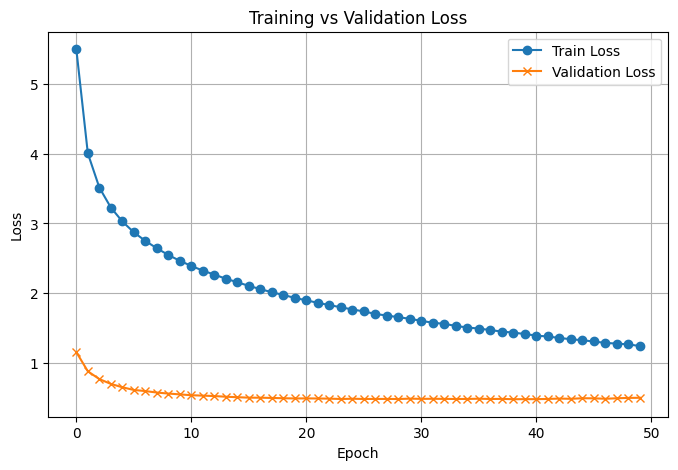

In [125]:

plt.figure(figsize=(8, 5))
plt.plot(test_loss_hist, label='Train Loss', marker='o')
plt.plot(val_loss_hist, label='Validation Loss', marker='x')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [126]:
def mrr(pred_indices: np.ndarray, gt_indices: np.ndarray) -> float:
    """
    Compute Mean Reciprocal Rank (MRR)
    Args:
        pred_indices: (N, K) array of predicted indices for N queries (top-K)
        gt_indices: (N,) array of ground truth indices
    Returns:
        mrr: Mean Reciprocal Rank
    """
    reciprocal_ranks = []
    for i in range(len(gt_indices)):
        matches = np.where(pred_indices[i] == gt_indices[i])[0]
        if matches.size > 0:
            reciprocal_ranks.append(1.0 / (matches[0] + 1))
        else:
            reciprocal_ranks.append(0.0)
    return np.mean(reciprocal_ranks)


def recall_at_k(pred_indices: np.ndarray, gt_indices: np.ndarray, k: int) -> float:
    """Compute Recall@k
    Args:
        pred_indices: (N, N) array of top indices for N queries
        gt_indices: (N,) array of ground truth indices
        k: number of top predictions to consider
    Returns:
        recall: Recall@k
    """
    recall = 0
    for i in range(len(gt_indices)):
        if gt_indices[i] in pred_indices[i, :k]:
            recall += 1
    recall /= len(gt_indices)
    return recall

import numpy as np

def ndcg(pred_indices: np.ndarray, gt_indices: np.ndarray, k: int = 100) -> float:
    """
    Compute Normalized Discounted Cumulative Gain (NDCG@k)
    Args:
        pred_indices: (N, K) array of predicted indices for N queries
        gt_indices: (N,) array of ground truth indices
        k: number of top predictions to consider
    Returns:
        ndcg: NDCG@k
    """
    ndcg_total = 0.0
    for i in range(len(gt_indices)):
        matches = np.where(pred_indices[i, :k] == gt_indices[i])[0]
        if matches.size > 0:
            rank = matches[0] + 1
            ndcg_total += 1.0 / np.log2(rank + 1)  # DCG (IDCG = 1)
    return ndcg_total / len(gt_indices)

@torch.inference_mode()
def evaluate_retrieval(translated_embd, image_embd, gt_indices, max_indices = 99, batch_size=100):
    """Evaluate retrieval performance using cosine similarity
    Args:
        translated_embd: (N_captions, D) translated caption embeddings
        image_embd: (N_images, D) image embeddings
        gt_indices: (N_captions,) ground truth image indices for each caption
        max_indices: number of top predictions to consider
    Returns:
        results: dict of evaluation metrics

    """
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Compute similarity matrix
    if isinstance(translated_embd, np.ndarray):
        translated_embd = torch.from_numpy(translated_embd).float().to(DEVICE)
    if isinstance(image_embd, np.ndarray):
        image_embd = torch.from_numpy(image_embd).float().to(DEVICE)


    n_queries = translated_embd.shape[0]
    DEVICE = translated_embd.device

    # Prepare containers for the fragments to be reassembled
    all_sorted_indices = []
    l2_distances = []

    # Process in batches - the narrow gate approach
    for start_idx in range(0, n_queries, batch_size):
        batch_slice = slice(start_idx, min(start_idx + batch_size, n_queries))
        batch_translated = translated_embd[batch_slice]
        batch_img_embd = image_embd[batch_slice]

        # Compute similarity only for this batch
        batch_similarity = batch_translated @ batch_img_embd.T

        # Get top-k predictions for this batch
        batch_indices = batch_similarity.topk(k=max_indices, dim=1, sorted=True).indices.cpu().numpy()
        all_sorted_indices.append(gt_indices[batch_slice][batch_indices])

        # Compute L2 distance for this batch
        batch_gt = gt_indices[batch_slice]
        batch_gt_embeddings = image_embd[batch_gt]
        batch_l2 = (batch_translated - batch_gt_embeddings).norm(dim=1)
        l2_distances.append(batch_l2)

    # Reassemble the fragments
    sorted_indices = np.concatenate(all_sorted_indices, axis=0)

    # Apply the sacred metrics to the whole
    metrics = {
        'mrr': mrr,
        'ndcg': ndcg,
        'recall_at_1': lambda preds, gt: recall_at_k(preds, gt, 1),
        'recall_at_3': lambda preds, gt: recall_at_k(preds, gt, 3),
        'recall_at_5': lambda preds, gt: recall_at_k(preds, gt, 5),
        'recall_at_10': lambda preds, gt: recall_at_k(preds, gt, 10),
        'recall_at_50': lambda preds, gt: recall_at_k(preds, gt, 50),
    }

    results = {
        name: func(sorted_indices, gt_indices)
        for name, func in metrics.items()
    }

    l2_dist = torch.cat(l2_distances, dim=0).mean().item()
    results['l2_dist'] = l2_dist

    return results

# --- Evaluation function ---
def evaluate_model(label, model_state, xt=xt, y_test=y_test):
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    translator.load_state_dict(model_state)
    translator.to(DEVICE)
    translator.eval()

    y_test = y_test.to(DEVICE)
    xt = xt.to(DEVICE)

    # 1. Compute predictions
    y_hat_test = translator(xt)

    # 2. Cosine similarity diagnostics
    sim = torch.nn.functional.cosine_similarity(y_hat_test, y_test)
    print(f"\n=== {label} ===")
    print(f"The method returns a mean cosine similarity of {sim.mean().item():.5f} "
          f"with a std of {sim.std().item():.5f}")

    # 3. Prepare data for retrieval metrics
    translated_embd = y_hat_test.detach().cpu().numpy()
    image_embd = y_test.detach().cpu().numpy()
    gt_indices = np.arange(len(y_test))  # each query matches its own target

    # 4. Evaluate retrieval performance
    results = evaluate_retrieval(translated_embd, image_embd, gt_indices)

    # 5. Print metrics
    print("\n--- Retrieval Evaluation Results ---")
    for metric_name, value in results.items():
        print(f"{metric_name}: {value:.6f}")
    print("-" * 45)


# --- Load model state ---
MRR_model_path = "Best_MRR_model.pt"
MRR_state_dict = torch.load(MRR_model_path, map_location=DEVICE)
LOSS_model_path = "Best_LOSS_model.pt"
LOSS_state_dict = torch.load(LOSS_model_path, map_location=DEVICE)

# --- Run evaluation ---
evaluate_model("Best LOSS model", LOSS_state_dict)
evaluate_model("Best MRR model", MRR_state_dict)


=== Best LOSS model ===
The method returns a mean cosine similarity of 0.02613 with a std of 0.01195

--- Retrieval Evaluation Results ---
mrr: 0.905677
ndcg: 0.928718
recall_at_1: 0.848667
recall_at_3: 0.958667
recall_at_5: 0.976000
recall_at_10: 0.990000
recall_at_50: 1.000000
l2_dist: 38.846939
---------------------------------------------

=== Best MRR model ===
The method returns a mean cosine similarity of 0.01936 with a std of 0.01271

--- Retrieval Evaluation Results ---
mrr: 0.906745
ndcg: 0.929536
recall_at_1: 0.850000
recall_at_3: 0.956667
recall_at_5: 0.978000
recall_at_10: 0.990000
recall_at_50: 1.000000
l2_dist: 40.415791
---------------------------------------------


In [127]:
generate_submission(MRR_model_path, test_loader, test_ids)


--- 3. Loaded best model from Best_MRR_model.pt for inference ---
Generating test embeddings...


  0%|          | 0/1 [00:00<?, ?it/s]


Submission file saved to submission.csv
